# 개요

## 학습 목표
    - 시간에 따른 특징을 갖는 시계열 데이터 다루기
    - RNN을 이용 주식 데이터 학습 및 다음날 종가 예측

## 학습 순서

<img src='./figs/06_01.png'>

# 이해하기 : RNN
- 순서가 있는 데이터는, 순서를 고려한 모델 설계를 해야 한다
- 모델이 과거와 현재 정보를 다 가지고 있어야 한다.
- 모델이 보낸 과거의 출력을, 다시 입력으로 넣어 주는, 되풀이(recurrent) 되는 구조
- 이를 RNN (recurrent neural network) 라고 한다

<img src='./figs/06_02.png'>

- RNN에서 각 신경망 각 층은 한 시점(cell)
- 모든 시점에서의 가중치는 전부 공유 되고 있음
- 모든 시점에서의 출력은 다음 시점의 입력값과 합쳐져 가중치가 적용
- 최종 출력값이 출력, 출력층 이전의 출력은 은닉 상태
- 입력층은 모델의 시작으로 이전의 은닉 상태가 존재하지 않아 랜덤한 값을 줌

## 장점
- 이전 정보를 현재 시점에 이용, 시간에 대한 정보 추출 가능
- 같은 가중치를 반복 사용, 가중치 수가 적다

## 단점
- 같은 가중치를 여러번 반복 사용, 계산 시간 오래 걸림
- 시계열이 길어질 수록 앞의 정보가 점점 흐려진다

# 데이터 살펴보기
- 넷플릭스 주가의 하루 시가, 고가, 저가 정보로
- 다음 날의 종가 예측

In [2]:
import pandas as pd

df = pd.read_csv('./datasets/CH06.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1009 non-null   object 
 1   Open    1009 non-null   float64
 2   High    1009 non-null   float64
 3   Low     1009 non-null   float64
 4   Volume  1009 non-null   int64  
 5   Close   1009 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 47.4+ KB


In [3]:
df.head()

,Date,Open,High,Low,Volume,Close
0,2018-02-05,262.000000,267.899994,250.029999,11896100,254.259995
1,2018-02-06,247.699997,266.700012,245.000000,12595800,265.720001
2,2018-02-07,266.579987,272.450012,264.329987,8981500,264.559998
3,2018-02-08,267.079987,267.619995,250.000000,9306700,250.100006
4,2018-02-09,253.850006,255.800003,236.110001,16906900,249.470001


In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Volume', 'Close'], dtype='object')

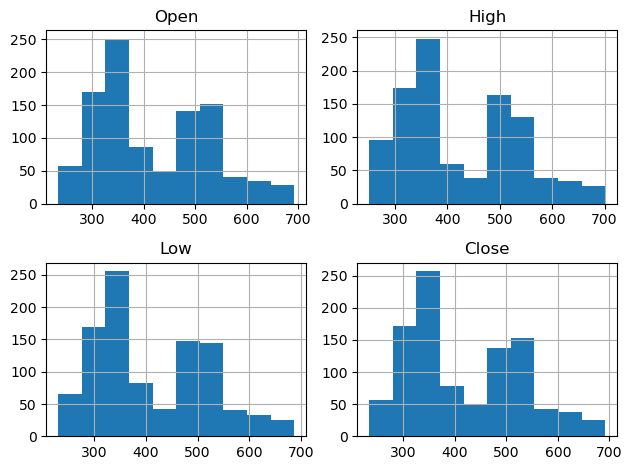

In [5]:
import matplotlib.pyplot as plt

cols = ['Open', 'High', 'Low', 'Close']
df_tmp = df[cols]
df_tmp.hist()
plt.tight_layout()
plt.show()

# 학습용 데이터 만들기

- RNN은 여러 시점의 값을 입력 받는다
- 입력 데이터에는 하루치 개장가, 최고가, 최저가를 묶어 입력 데이터의 한 시점으로 본다
- 종가 데이터는 하루치 종가를 한 시점으로 본다
- 배치 단위는 30일 치로 한다. (원하는 대로 하면 되는 값)
- 오늘의 개장가, 최고가, 최저가로, 내일의 종가를 맞추는 것이 목적

<img src='./figs/06_03.png'>

In [6]:
df

,Date,Open,High,Low,Volume,Close
0,2018-02-05,262.000000,267.899994,250.029999,11896100,254.259995
1,2018-02-06,247.699997,266.700012,245.000000,12595800,265.720001
2,2018-02-07,266.579987,272.450012,264.329987,8981500,264.559998
3,2018-02-08,267.079987,267.619995,250.000000,9306700,250.100006
4,2018-02-09,253.850006,255.800003,236.110001,16906900,249.470001
...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,20047500,427.140015
1005,2022-02-01,432.959991,458.480011,425.540009,22542300,457.130005
1006,2022-02-02,448.250000,451.980011,426.480011,14346000,429.480011
1007,2022-02-03,421.440002,429.260010,404.279999,9905200,405.600006


In [7]:
import numpy as np
from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
    def __init__(self):
        self.df = pd.read_csv('./datasets/CH06.csv')
        target_cols = ['Open', 'High', 'Low', 'Close']
        self.df = self.df[target_cols]
        self.df = (self.df - np.min(self.df, axis=0))/(np.max(self.df, axis=0) - np.min(self.df, axis=0))
        
        self.data = self.df.iloc[:, :-1]
        self.label = self.df.iloc[:, -1]        
        
    def __len__(self):
        return len(self.data) - 30 # 사용 가능한 배치 개수
    
    def __getitem__(self, i):
        data = self.data[i:i+30].values # i+0~29일 간의 data
        label = self.label[i+30] # i+30일의 label
        return data, label

<img src='./figs/06_04.png'>

# RNN 모델 정의하기

<img src='./figs/06_05.png'>

- RNN 층의 동그라미 하나가 시점 (배치마다 30일치 시점 사용, 동그라미가 30개 여야)
- 각 시점에서 출력, 즉 은닉 상태가 다음 RNN 층과 같은 시점과, 같은 RNN층의 다음 시점으로 들어감
- RNN의 출력을 MLP 로 입력

<img src='./figs/06_06.png'>

In [8]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        # RNN층 정의
        self.rnn = nn.RNN(input_size=3, hidden_size=8, 
                          num_layers=5, batch_first=True) 
        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x, h0):
        x, h0 = self.rnn(x, h0)
        
        x = torch.reshape(x, (x.shape[0], -1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)        
        
        x = torch.flatten(x)
        return x

- input_size: RNN 모델의 입력 벡터의 크기입니다. 즉, 각 시점(time step)의 입력으로 주어지는 데이터의 차원 수를 의미합니다. input_size=3이면 각 시점에서 3차원(개장가, 최고가, 최저가)의 입력이 주어진다는 것을 의미합니다.

- hidden_size: RNN 모델의 은닉 상태 벡터의 크기입니다. RNN은 시간에 따라 정보를 전달하면서 내부적으로 은닉 상태를 유지합니다. hidden_size는 은닉 상태의 차원 수를 나타냅니다. 이 값은 RNN이 가진 은닉 상태의 표현 능력을 결정합니다. 더 큰 hidden_size는 더 많은 정보를 저장할 수 있지만, 모델의 파라미터 수와 계산 비용이 증가할 수 있습니다.

- num_layers: RNN 모델의 층(layer) 수를 의미합니다. RNN을 여러 층으로 쌓을 경우, 이를 통해 더 복잡한 시계열 패턴을 학습할 수 있습니다. num_layers=5는 5개의 RNN 층을 쌓는다는 것을 의미합니다.

    - hidden_size는 RNN의 각 층에서의 은닉 상태 벡터의 크기를 지정하는 것이며, num_layers는 RNN 층을 여러 개 쌓는데 사용되는 매개변수입니다. hidden_size는 각 층에서의 은닉 상태 벡터의 크기를 결정하고, num_layers는 여러 층을 쌓아서 더 복잡한 모델을 구성할 수 있도록 합니다.

- batch_first는 배치 차원이 가장 앞에 오게 하는 것 (32가 배치 차원), 여기서는, (32, 30, 3) (배치, 30일치, 개장가/최고가/최저가)
- fc1의 in_features는, 30일치*hidden_size(8) = 240 (아래 식 참조)
- RNN층은 출력이 2개
    - x는 마지막 RNN 층의 은닉상태 (우리가 사용 할 값)
    - 두번째 hn 은 모든 RNN 층의 은닉 상태
- 시계열의 차원을 제거해 MLP의 입력으로 사용 (2차원을 1차원으로 바뀜)

<img src='./figs/rnn.png'>

- [소스](https://wikidocs.net/22886)

<img src='./figs/06_07.png'>

- MLP 층으로 종가 예측 
- 종가는 하나의 숫자, (배치, 1) 형태

# 모델 학습하기

<img src='./figs/06_08.png'>

In [9]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
model = RNN().to(device)
dataset = Netflix()
loader = DataLoader(dataset, batch_size=32)
optim = Adam(params=model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss().to(device)

In [11]:
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        data, label = data.to(device), label.type(torch.FloatTensor).to(device)
        optim.zero_grad()
        
        h0 = torch.zeros(5, data.shape[0], 8).to(device) # 은닉층 개수, 배치 크기, 출력 차원
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        
        loss = loss_fn(pred, label)
        loss.backward()
        optim.step()
        
        iterator.set_description(f'epoch : {epoch+1}, loss : {loss.item():.3f}')
        
torch.save(model.state_dict(), './models/rnn.pth')        

epoch : 101, loss : 0.050: 100%|███████████████| 31/31 [00:00<00:00, 287.57it/s]


epoch : 200, loss : 0.021: 100%|███████████████| 31/31 [00:00<00:00, 302.42it/s]


- 초기 은닉층의 상태는 모든 요소가 0으로 구성, shape은 (은닉층 개수, 배치 크기, 출력 차원)

# 모델 성능 평가

In [17]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)

preds = []
total_loss = 0

with torch.no_grad():
    # 모델 가중치 불러오기
    model.load_state_dict(torch.load('./models/rnn.pth', map_location=device))
    
    for data, label in loader:
        data, label = data.to(device), label.to(device)
        
        h0 = torch.zeros(5, data.shape[0], 8).to(device) # 은닉층 개수, 배치 크기, 출력 차원
        
        # 모델 예측값 출력
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())
        
        loss = loss_fn(pred, label)
        total_loss += loss/len(loader)
        
total_loss.item()        

0.002297221045403964

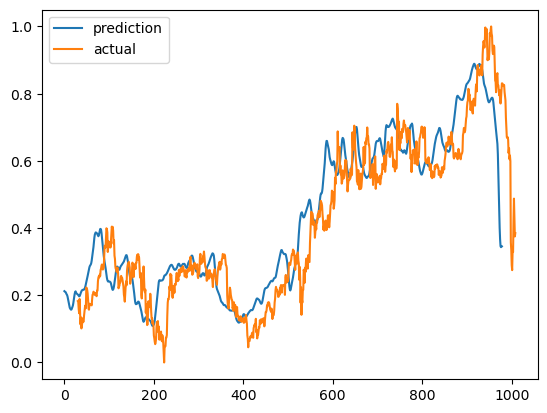

In [19]:
plt.plot(preds, label='prediction')
plt.plot(dataset.label[30:], label='actual')
plt.legend()
plt.show()

# 마무리

<img src='./figs/06_09.png'>

# 연습문제

<img src='./figs/06_10.png'>